In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_day = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date = last_day[0]
print(f"Last date: {last_date}")

# Calculate the date 1 year ago from the last data point in the database
year_before = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=366)
print(f"Year before last date: {year_before}")

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
year_prcp = session.query(*sel).\
    filter(measurement.date >= year_before).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_prcp, columns=['date', 'prcp'])
df.set_index("date", inplace=True)

# Sort the dataframe by date
df = df.sort_values(by="date", ascending=True)
df.head()

Last date: 2017-08-23
Year before last date: 2016-08-22 00:00:00


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


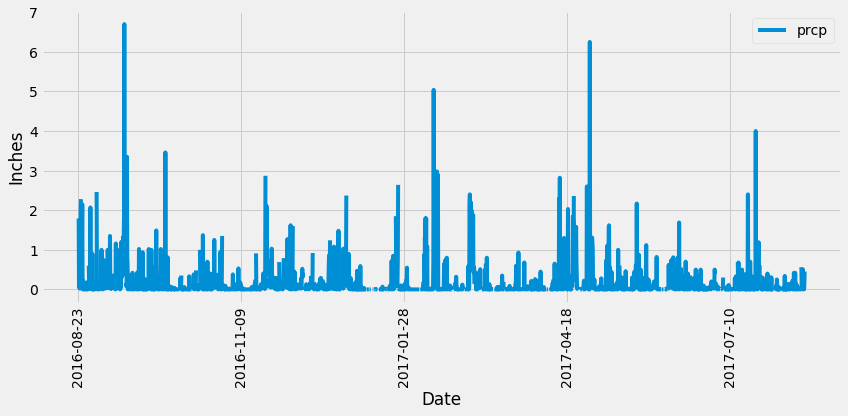

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
measurement_stations = session.query(measurement.station).distinct().count()
print(f"Stations available in this dataset: {measurement_stations}")

Stations available in this dataset: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
group_stations = session.query(measurement.station, 
                               func.count(measurement.station)).group_by(measurement.station)
order_stations = group_stations.order_by(func.count(measurement.station).desc()).all()
print(f"Most active stations:") 
order_stations

Most active stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = order_stations[0][0]
print(f"Most acitve station: {most_active}")

# Query max/min/average temps from the most active station
min_temp_most_active = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active).all()
max_temp_most_active = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active).all()
avg_temp_most_active = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active).all()

print(f"Highest temp: {max_temp_most_active[0][0]}")
print(f"Lowest temp: {min_temp_most_active[0][0]}")
print(f"Average temp: {avg_temp_most_active[0][0]}")

Most acitve station: USC00519281
Highest temp: 85.0
Lowest temp: 54.0
Average temp: 71.66378066378067


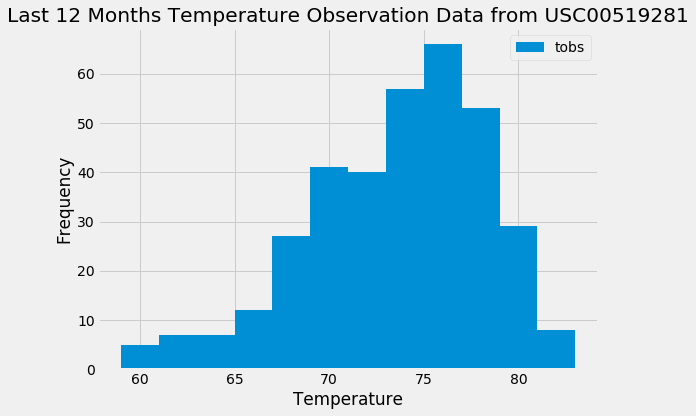

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps_most_active = session.query(measurement.tobs).filter(measurement.station == most_active).filter(measurement.date >= year_before).all()
last_year_temps_df = pd.DataFrame(last_year_temps_most_active)
last_year_temps_df.plot.hist(bins=12, figsize=(9,6), title="Last 12 Months Temperature Observation Data from USC00519281")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()